In [24]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Introdução e Coleta de Dados
Coleta de dados para PETR4 (último ano)

# Objetivo do Notebook

Este notebook apresenta, de forma prática e didática, o ciclo básico de um projeto de Machine Learning aplicado ao mercado financeiro. O objetivo é demonstrar como coletar, preparar, modelar e avaliar dados reais, além de refletir sobre erros comuns e boas práticas.

In [25]:
df = yf.download("PETR4.SA", period="1y")

C:\Users\neto\AppData\Local\Temp\ipykernel_1916\3133357418.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("PETR4.SA", period="1y")
[*********************100%***********************]  1 of 1 completed



In [42]:
print(df)

Price           Close       High        Low       Open    Volume        Gap  \
Date                                                                          
2024-07-30  31.272743  31.375136  31.050888  31.153281  16040700   0.000000   
2024-07-31  31.921238  31.921238  31.537261  31.614056  28561100   0.341313   
2024-08-01  31.434864  32.279613  31.392201  32.211349  29756300   0.290111   
2024-08-02  30.487724  31.400735  30.487724  31.332474  36483900  -0.102390   
2024-08-05  30.462128  30.462128  29.523517  29.694174  44765900  -0.793551   
...               ...        ...        ...        ...       ...        ...   
2025-07-23  31.990000  32.029999  31.299999  31.350000  27418600   0.000000   
2025-07-24  31.940001  32.020000  31.650000  31.930000  17856300  -0.059999   
2025-07-25  31.980000  32.180000  31.910000  31.990000  13341000   0.049999   
2025-07-28  32.020000  32.430000  31.680000  32.160000  27972800   0.180000   
2025-07-29  32.439999   0.000000   0.000000   0.0000

# Pré-processamento
Criação de variável GAP (diferença abertura - fechamento anterior)

In [26]:
df['Gap'] = df['Open'] - df['Close'].shift(1)

In [43]:
print(df['Gap'])

Date
2024-07-30     0.000000
2024-07-31     0.341313
2024-08-01     0.290111
2024-08-02    -0.102390
2024-08-05    -0.793551
                ...    
2025-07-23     0.000000
2025-07-24    -0.059999
2025-07-25     0.049999
2025-07-28     0.180000
2025-07-29   -32.020000
Name: Gap, Length: 249, dtype: float64


Criação de label:

    1 se GAP fecha (Close >= Close anterior), 0 caso contrário

## Erro de MultiIndex no DataFrame

Ao baixar dados do 'Yahoo Finance' para apenas um 'ticker', o 'pandas' criou um 'DataFrame' com 'MultiIndex' nas colunas (níveis: 'Price' e 'Ticker'). Isso fez com que operações como `df['Close']` retornem um 'DataFrame', não uma 'Series', causando erro ao criar novas colunas.

**Como resolvi:**

Removi o 'MultiIndex' das colunas, deixando apenas o nome do preço (ex: 'Close', 'Open', etc). Assim, o 'DataFrame' fica mais simples e compatível com as operações seguintes.

In [41]:
# Remover MultiIndex das colunas, mantendo apenas o primeiro nível
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)
print(df.columns)

Index(['Close', 'High', 'Low', 'Open', 'Volume', 'Gap', 'Gap_Close',
       'Return_1d'],
      dtype='object', name='Price')


Feature adicional: Retorno diário

In [29]:
df['Return_1d'] = df['Close'].pct_change()

In [44]:
print(df['Return_1d'] )

Date
2024-07-30   -0.006237
2024-07-31    0.020737
2024-08-01   -0.015237
2024-08-02   -0.030130
2024-08-05   -0.000840
                ...   
2025-07-23    0.020415
2025-07-24   -0.001563
2025-07-25    0.001252
2025-07-28    0.001251
2025-07-29    0.013117
Name: Return_1d, Length: 249, dtype: float64


Remover valores ausentes

In [30]:
df = df.dropna()

# Preparação dos Dados para Modelo

In [31]:
X = df[['Gap', 'Return_1d']]
y = df['Gap_Close']

In [47]:
print(X)

Price             Gap  Return_1d
Date                            
2024-07-30  -0.315721  -0.006237
2024-07-31   0.341313   0.020737
2024-08-01   0.290111  -0.015237
2024-08-02  -0.102390  -0.030130
2024-08-05  -0.793551  -0.000840
...               ...        ...
2025-07-23   0.000000   0.020415
2025-07-24  -0.059999  -0.001563
2025-07-25   0.049999   0.001252
2025-07-28   0.180000   0.001251
2025-07-29 -32.020000   0.013117

[249 rows x 2 columns]


In [48]:
print(y)

Date
2024-07-30    0
2024-07-31    1
2024-08-01    0
2024-08-02    0
2024-08-05    0
             ..
2025-07-23    0
2025-07-24    0
2025-07-25    1
2025-07-28    1
2025-07-29    1
Name: Gap_Close, Length: 249, dtype: int64


Divisão temporal (sem shuffle para respeitar série temporal)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Modelo de Machine Learning

In [33]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


# Avaliação

In [34]:
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print("Relatório de Classificação:\n", report)

Relatório de Classificação:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94        28
           1       0.88      1.00      0.94        22

    accuracy                           0.94        50
   macro avg       0.94      0.95      0.94        50
weighted avg       0.95      0.94      0.94        50



# Visualizações

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Visualização do GAP ao longo do tempo

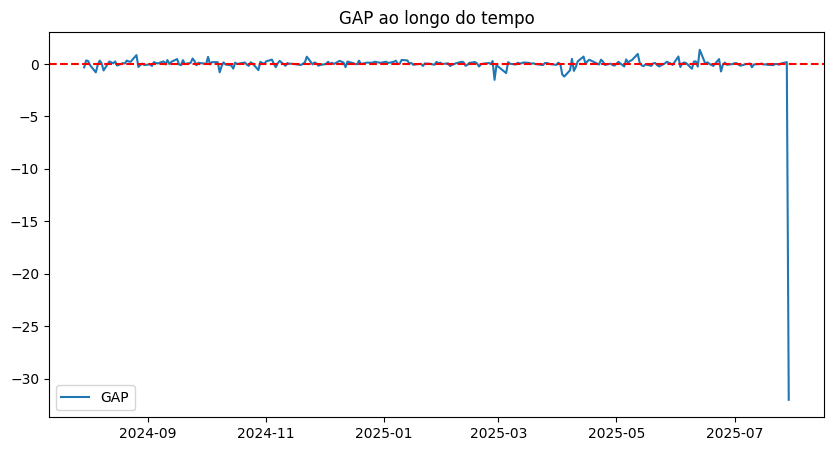

In [36]:
plt.figure(figsize=(10,5))
plt.plot(df.index, df['Gap'], label='GAP')
plt.axhline(0, color='red', linestyle='--')
plt.title('GAP ao longo do tempo')
plt.legend()
plt.show()

# Matriz de confusão

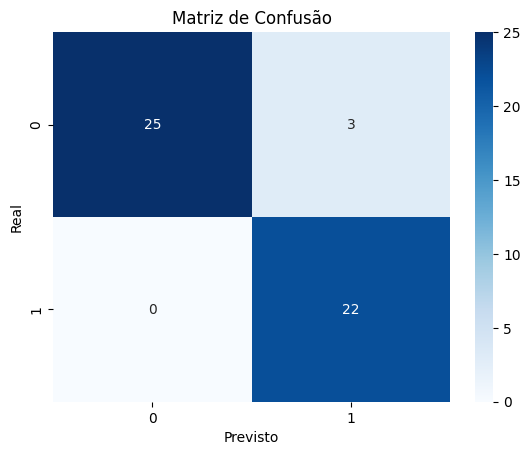

In [37]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()

# Importância das variáveis

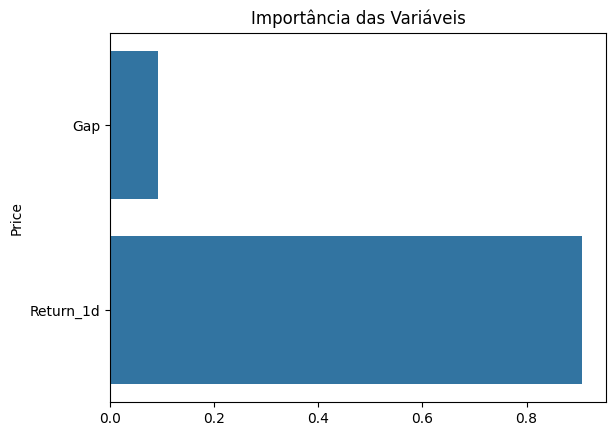

In [49]:
importances = model.feature_importances_
features = X.columns
sns.barplot(x=importances, y=features)
plt.title('Importância das Variáveis')
plt.show()

# Conclusões e Aprendizados

- O notebook mostra todo o fluxo de um projeto de machine learning aplicado ao mercado financeiro, desde a coleta de dados até a avaliação do modelo.
- O tratamento do DataFrame após o download dos dados é fundamental, pois o pandas pode criar estruturas inesperadas (MultiIndex), exigindo atenção antes de seguir com a análise.
- A criação de variáveis como GAP e retorno diário é essencial para enriquecer o modelo e entender o comportamento do ativo.
- O uso de RandomForest permite avaliar a capacidade preditiva dessas variáveis para o fechamento do gap.
- Visualizações e métricas ajudam a interpretar o desempenho do modelo e a importância das features.
- Documentar e aprender com os erros (como o do MultiIndex) faz parte do processo e contribui para o crescimento como cientista de dados.

**Próximos passos no módulo seguinte:**
- Testar outros modelos e hiperparâmetros.
- Explorar mais features (ex: médias móveis, volatilidade, indicadores técnicos).
- Avaliar o modelo em outros ativos ou períodos.
- Implementar validação cruzada específica para séries temporais.